In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
import numba
from numba import jit
import scipy.optimize as spopt
from scipy.optimize import curve_fit
import matplotlib.gridspec as gridspec
import animatplot as amp

In [2]:
@numba.jit(nopython=True)

# this function determines the coupling energy based on the location of the spin
def rates_2d_numba(J,H,state,omega0=1):
    # shift the lattices and remove some neighbours for the edges
    left = np.empty(state.shape)
    right = np.empty(state.shape)
    top = np.empty(state.shape)
    bottom = np.empty(state.shape)
    
    # roll the states (in the dumb numba way)
    for i in range(state.shape[0]):
        left[i,:] = np.roll(state[i,:],1)
        right[i,:] = np.roll(state[i,:],-1)
        top[:,i] = np.roll(state[:,i],1)
        bottom[:,i] = np.roll(state[:,i],-1)
    
    # remove edges
    left[:,0] = 0.
    right[:,-1] = 0.
    top[0,:] = 0.
    bottom[-1,:] = 0.
    
    # compute coupling summation for each spin
    coupling = J*state*(left + right + top + bottom)
    
    # energy difference associated to external field
    field = H*state
    
    # return the rates
    return omega0*np.exp(-(coupling + field))

In [3]:
@numba.jit(nopython=True)

# function that implements dynamic Ising model using Gillespie's algorithm
def ensemble_averaged_ising(n_samples,n_steps,tf,L,J,
                 step_change=10**9,cbase=100,cnew=100,Ki=18,Ka=2900):

    # array to store all results
    all_states = np.zeros((n_samples,n_steps,L,L),dtype='float64')
    
    # regular time steps
    t_grid = np.linspace(0,tf,n_steps)
    
    # define zero energy
    # chosen such that average activity is 0.5 without coupling at c=100
    epsilon = -np.log((1 + 100/Ki)/(1 + 100/Ka))
    
    ########################
    ### Actual algorithm ###
    ########################
    
    # loop over n_samples realisations of the algorithm
    for sample in range(n_samples):
        # initialise each realisation
        dt = 0
        time = 0
        
        # initialise
        state = np.random.choice(np.array([-1.,1.]),size=(L,L))
        
        # loop over all time steps
        for step in range(n_steps):
            # change concentration after some steps
            if step >= step_change:
                c = cnew
            else:
                c = cbase
                            
            # define the external field
            H = -0.5*(epsilon + np.log((1 + c/Ki)/(1 + c/Ka)))
            
            # ensure initialisation; not necessary after initial round
            if time == 0:
                # obtain rates of flipping
                rates = rates_2d_numba(J,H,state)
                Omega = np.sum(rates)
                
                # select which spin i is flipped
                p = np.random.uniform(0,1)*Omega
                mask = p < np.cumsum(rates)
                i = np.where(mask == True)[0][0]

                # convert to coordinates in the lattice
                m,l = np.divmod(i,L)

                # sample time until next event
                u1 = np.random.uniform(0,1)
                dt = -np.log(u1)/Omega
            
                # update time
                time += dt
              
            # keep updating until we reach the end of this regular time step
            while time < t_grid[step]:
                # flip the spin
                state[m,l] *= -1
                
                # obtain rates of flipping
                rates = rates_2d_numba(J,H,state)
                Omega = np.sum(rates)
                
                # select which spin i is flipped
                p = np.random.uniform(0,1)*Omega
                mask = p < np.cumsum(rates)
                i = np.where(mask == True)[0][0]

                # convert to coordinates in the lattice
                m,l = np.divmod(i,L)

                # sample time until next event
                u1 = np.random.uniform(0,1)
                dt = -np.log(u1)/Omega
            
                # update time
                time += dt
                
            # save the last state before passing the boundary
            all_states[sample,step,:,:] = state
            
    #################
    ### Averaging ###
    #################
    
    # array to store ensemble average for each spin
    ensemble_av = np.zeros((n_steps,L,L),dtype='float64')
    
    # averaging (the weird numba way)
    for step in range(n_steps):
        for spin1 in range(L):
            for spin2 in range(L):
                ensemble_av[step,spin1,spin2] = np.mean(all_states[:,step,spin1,spin2])
        
    return all_states, ensemble_av, t_grid

In [4]:
@numba.jit(nopython=True)
# function for averaging over two axes
def lattice_mean(lattice):
    return np.sum(np.sum(lattice[:,:,:],axis=-1),axis=-1)/lattice[0,:,:].size

@numba.jit(nopython=True)
# function for finding several realisations of single-cell activity
def activity_finder_nometh(n_steps,tf,n_samples,Nc,L,J):
    # array to save results
    all_act = np.zeros((n_steps,n_samples))
    
    for sample in range(n_samples):
        # obtain a realisation
        _, cell_av, time = ensemble_averaged_ising(Nc,n_steps,tf,L,J)
        
        # extract activity
        all_act[:,sample] = 0.5*(lattice_mean(cell_av) + 1)
        
    return all_act, time

def autocorr(all_act,time,co):   
    # obtain average of product 
    ata0_av = np.mean(all_act[co:,:]*all_act[co,:],axis=1)
    
    # obtain factors for product of averages
    at_av = np.mean(all_act[co:,:],axis=1)
    a0_av = np.mean(all_act[co,:])
    
    # shift time
    time_s = time[co:] - time[co]
    
    # return the autocorrelator: average of product minus product of averages
    return ata0_av-at_av*a0_av, time_s

Parameters of best fit: [sigma_N, tau_N] = [0.14038664 1.17313577]
Standard deviations: [0.0006051047975570033, 0.014464270337431263]


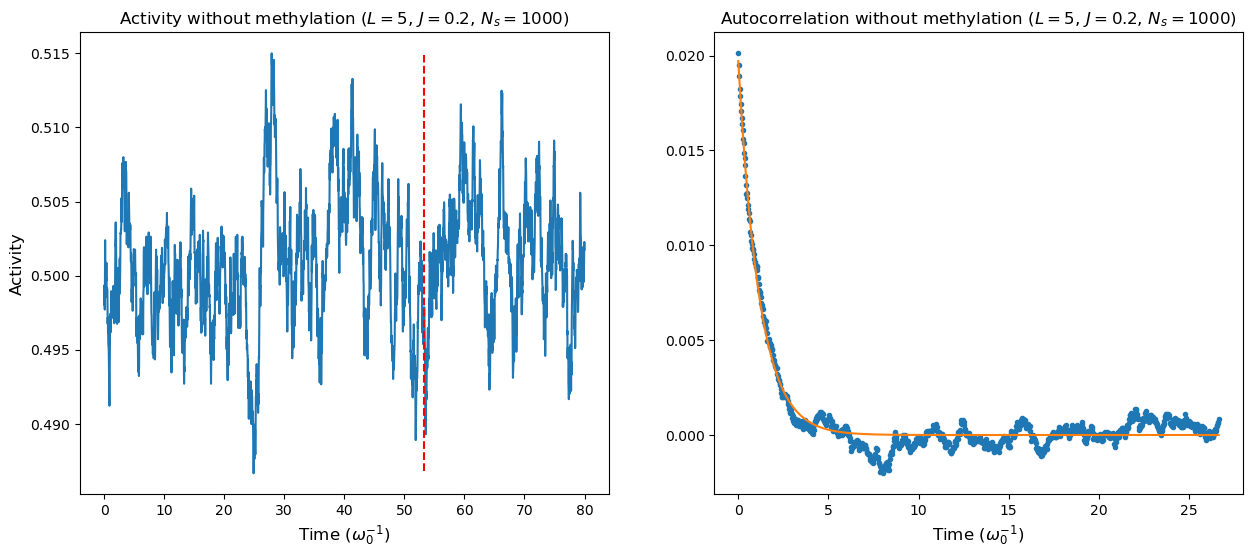

Estimates of tau_N in ms: 21.32974118779096


In [13]:
# time-related parameters
n_steps = 3000
tf = 80
co = 2000

# cluster-related parameters
n_samples = 1000
Nc = 1
L = 5
J = 0.2
omega0 = 55

# obtain activities
all_act, time = activity_finder_nometh(n_steps,tf,n_samples,Nc,L,J)

# obtain autocorrelation
auto_corr, time_s = autocorr(all_act,time,co)

# show results
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))

ax1.plot(time,np.mean(all_act,axis=1))
ax1.set_xlabel(r'Time $(\omega_0^{-1})$',size=12)
ax1.set_ylabel('Activity',size=12)
ax1.set_title(f'Activity without methylation $(L={L},\, J={J},\, N_s={n_samples})$')
ax1.axvline(x=tf*co/n_steps,ymin=0.05,ymax=0.95,color='r',linestyle='--')

# fit an exponential 
def noise_nometh(t,sigma_N,tau_N):
    return sigma_N**2*np.exp(-t/tau_N)

popt, pcov = curve_fit(noise_nometh,time_s,auto_corr)

# show the data with fit
print('Parameters of best fit: [sigma_N, tau_N] =', popt)
print('Standard deviations:', [np.sqrt(pcov[i,i]) for i in range(2)])

ax2.plot(time_s,auto_corr,'.')
ax2.plot(time_s,noise_nometh(time_s,*popt))
ax2.set_xlabel(r'Time $(\omega_0^{-1})$',size=12)
ax2.set_title(f'Autocorrelation without methylation $(L={L},\, J ={J},\, N_s={n_samples})$')

plt.show()

print('Estimates of tau_N in ms:', 1000*popt[1]/omega0)

In [10]:
# time-related parameters
n_steps = 3000
tf = 80
co = 2000

# cluster-related parameters
n_samples = 1000
Nc = 1
L = 5
J = 0.2
omega0 = 55

# obtain activities
all_act, time = activity_finder_nometh(n_steps,tf,n_samples,Nc,L,J)

# obtain autocorrelation
auto_corr, time_s = autocorr(all_act,time,co)

# show results
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))

ax1.plot(time,np.mean(all_act,axis=1))
ax1.set_xlabel(r'Time $(\omega_0^{-1})$',size=12)
ax1.set_ylabel('Activity',size=12)
ax1.set_title(f'Activity without methylation $(L={L},\, J={J},\, N_s={n_samples})$')
ax1.axvline(x=tf*co/n_steps,ymin=0.05,ymax=0.95,color='r',linestyle='--')

# fit an exponential 
def noise_nometh(t,sigma_N,tau_N):
    return sigma_N**2*np.exp(-t/tau_N)

popt, pcov = curve_fit(noise_nometh,time_s,auto_corr)

# show the data with fit
print('Parameters of best fit: [sigma_N, tau_N] =', popt)
print('Standard deviations:', [np.sqrt(pcov[i,i]) for i in range(2)])

ax2.plot(time_s,auto_corr,'.')
ax2.plot(time_s,noise_nometh(time_s,*popt))
ax2.set_xlabel(r'Time $(\omega_0^{-1})$',size=12)
ax2.set_title(f'Autocorrelation without methylation $(L={L},\, J ={J},\, N_s={n_samples})$')

plt.show()

print('Estimates of tau_N in ms:', 1000*popt[1]/omega0)

Estimates of tau_N in ms: 1.5180816344211212


In [32]:
# fit an exponential 
def noise_nometh(t,sigma_N,tau_N):
    return sigma_N**2*np.exp(-t/tau_N)

# basic linear regression
def lin_fit(x,a,b):
    return a + b*x

# function for estimating omega0
def noise_estimator(n_samples,Nc,L,J_arr,n_steps,co,tf,J_est,
                     global_plot=False,lin_regress=True):
    
    # arrays to store fitted parameters and error bars
    parm_arr = np.zeros((2,J_arr.size))
    sd_arr = np.zeros_like(parm_arr)

    # prepare figure and get a nice color map
    fig, ax = plt.subplots(1, 1, figsize=(7,4))
    colormap = matplotlib.colormaps.get_cmap('coolwarm')

    # for various J
    for i,J in enumerate(J_arr):
        # obtain activities
        all_act, time = activity_finder_nometh(n_steps,tf,n_samples,Nc,L,J)

        # obtain autocorrelation
        auto_corr, time_s = autocorr(all_act,time,co)
        
        # perform fitting
        popt, pcov = curve_fit(noise_nometh,time_s,auto_corr)
        parm_arr[:,i] = popt
        sd_arr[:,i] = [np.sqrt(pcov[j,j]) for j in range(2)]
        
        ax.plot(time_s,auto_corr,'.')
        ax.plot(time_s,noise_nometh(time_s,*popt),label=f'$J={np.round(J,2)}$')

    # formatting
    # count the number of plots
    ax = plt.gca()
    lines = ax.lines
    n_plots = len(lines)

    # apply the same color to each pair of plots
    for plot in range(0, n_plots, 2):
        # choose a colour
        random_color = colormap(plot/n_plots + 0.1)

        # colour the plots
        lines[plot].set_color(random_color)
        lines[plot+1].set_color(random_color)
    
    ax.set_xlabel(r'Time $(\omega_0^{-1})$',size=12)
    ax.set_ylabel(r'Autocorrelator',size=12)
    ax.set_title(f'Autocorrelation without methylation $(L={L},\, J ={J},\, N_s={n_samples})$')

    # code for placing legend next to figure
    lgnd = ax.get_position()
    ax.set_position([lgnd.x0, lgnd.y0, lgnd.width * 0.9, lgnd.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()
    
    # additional results to show how noise parameters depend on J globally
    if global_plot == True:
        # define the critical value
        J_crit_inf = 0.5*np.log(1 + np.sqrt(2))
        J_crit_fin = J_crit_inf/(1-1.25/L)

        # show how the fitting parameters depend on J
        fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))

        for i,ax in enumerate((ax1, ax2)):
            ax.set_xlabel(r'$J$',size=12)
            ax.axvline(x=J_crit_fin,ymin=0.05,ymax=0.95,linestyle='--',color='r',label=r'$J^*_L$')
            ax.axvline(x=J_est,ymin=0.05,ymax=0.95,linestyle='--',color='grey',label=r'$\hat{J}_L$')
            ax.legend(fontsize=12)

        ax1.plot(J_arr,parm_arr[0,:],'o')
        ax1.set_ylabel(r'$\sigma_N$',size=12)
        ax1.set_title(f'Fitted noise amplitudes ($L={L}, N_s={n_samples}$)')

        ax2.semilogy(J_arr,parm_arr[1,:],'o')
        ax2.set_ylabel(r'$\tau_N \; (\omega_0^{-1})$',size=12)
        ax2.set_title(f'Fitted decay times ($L={L}, N_s={n_samples}$)')

        plt.show()
    
    # additional results if want precise estimate of omega0
    if lin_regress == True:

        #######################
        ## Linear regression ##
        #######################

        # regress J on G
        popt_GJ, pcov_GJ = curve_fit(lin_fit,parm_arr[0,:],J_arr)

        # regress tau on J
        popt_Jtau, pcov_Jtau = curve_fit(lin_fit,J_arr,np.log10(parm_arr[1,:]))

        # regress tau on G
        popt_Gtau, pcov_Gtau = curve_fit(lin_fit,parm_arr[0,:],np.log10(parm_arr[1,:]))

        # show results of fitting procedure
        fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(18,4))

        ax1.plot(parm_arr[0,:],J_arr,'o')
        ax1.plot(parm_arr[0,:],lin_fit(parm_arr[0,:],*popt_GJ))
        ax1.set_xlabel(r'$G$',size=12)
        ax1.set_ylabel(r'$J$',size=12)
        ax1.fill_betweenx([J_arr[0],J_arr[-1]],1.70,1.76,alpha=0.3)

        ax2.plot(J_arr,np.log10(parm_arr[1,:]),'o')
        ax2.plot(J_arr,lin_fit(J_arr,*popt_Jtau))
        ax2.set_xlabel(r'$J$',size=12)
        ax2.set_ylabel(r'$\log \tau_r$',size=12)

        ax3.plot(parm_arr[0,:],np.log10(parm_arr[1,:]),'o')
        ax3.plot(parm_arr[0,:],lin_fit(parm_arr[0,:],*popt_Gtau))
        ax3.set_xlabel(r'$G$',size=12)
        ax3.set_ylabel(r'$\log \tau_r$',size=12)
        ax3.fill_betweenx([np.min(np.log10(parm_arr[1,:])),np.max(np.log10(parm_arr[1,:]))],1.70,1.76,alpha=0.3)

        plt.show()

        # get point estimates
        Jest = lin_fit(1.73,*popt_GJ)

        print('Estimate of J:', Jest)
        print('Estimate of tau_r via J:', lin_fit(Jest,*popt_Jtau))
        print('   Estimate of omega0 in 1/s for tau_r=1/60 s:', 10**lin_fit(Jest,*popt_Jtau)/(1/60))
        print('   Estimate of omega0 in 1/s for tau_r=0.1 s:', 10**lin_fit(Jest,*popt_Jtau)/0.1)
        print('Estimate of tau_r via G:', lin_fit(1.73,*popt_Gtau))
        print('   Estimate of omega0 in 1/s for tau_r=1/60 s:', 10**lin_fit(1.73,*popt_Gtau)/(1/60))
        print('   Estimate of omega0 in 1/s for tau_r=0.1 s:', 10**lin_fit(1.73,*popt_Gtau)/0.1)

        # return the estimates for J and omega0; we take the value estimated via G with taur = 100 ms
        return Jest, 10**lin_fit(1.73,*popt_Gtau)/0.1

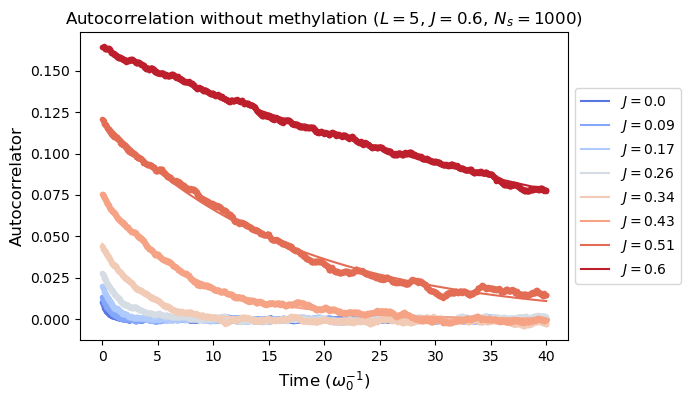

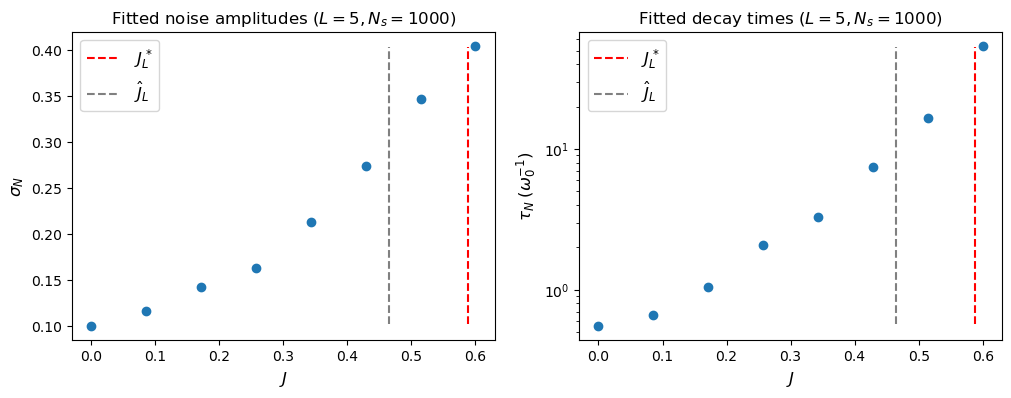

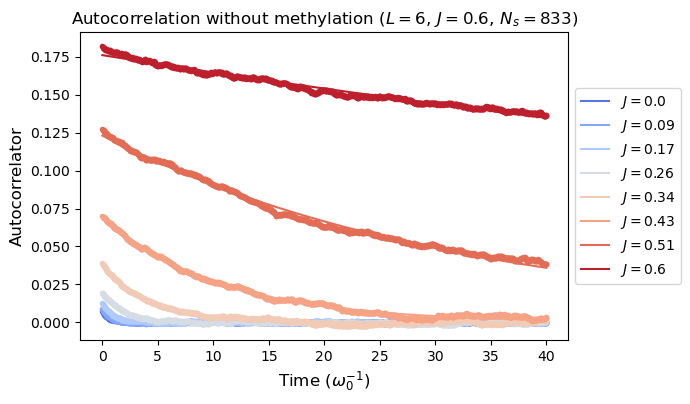

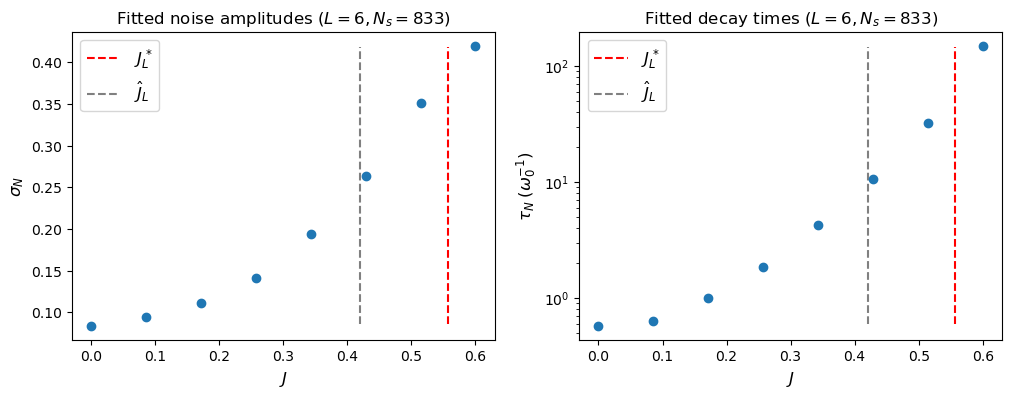

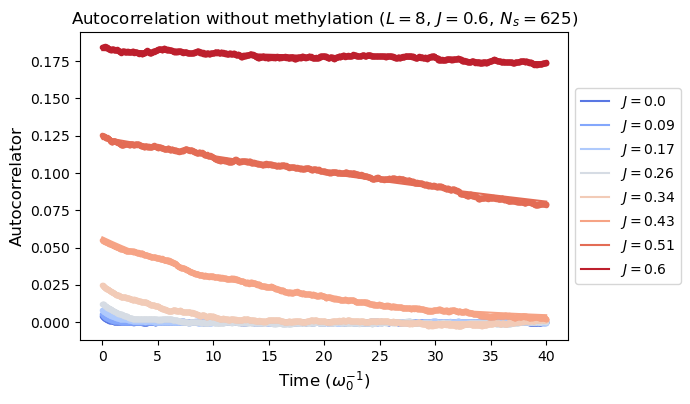

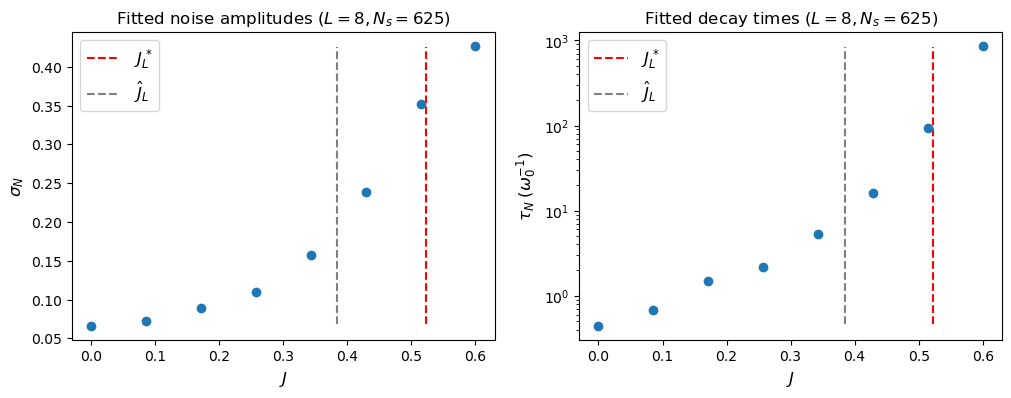

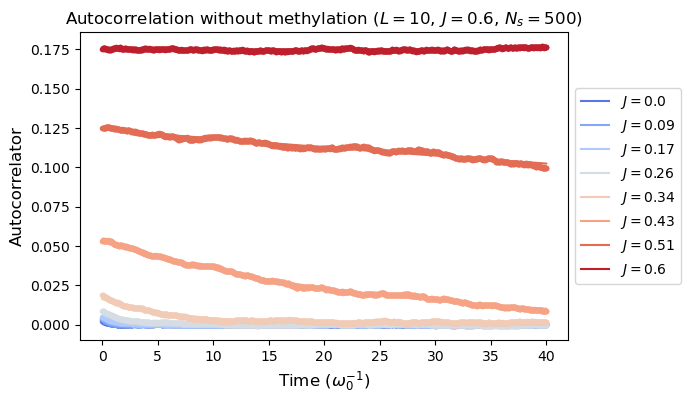

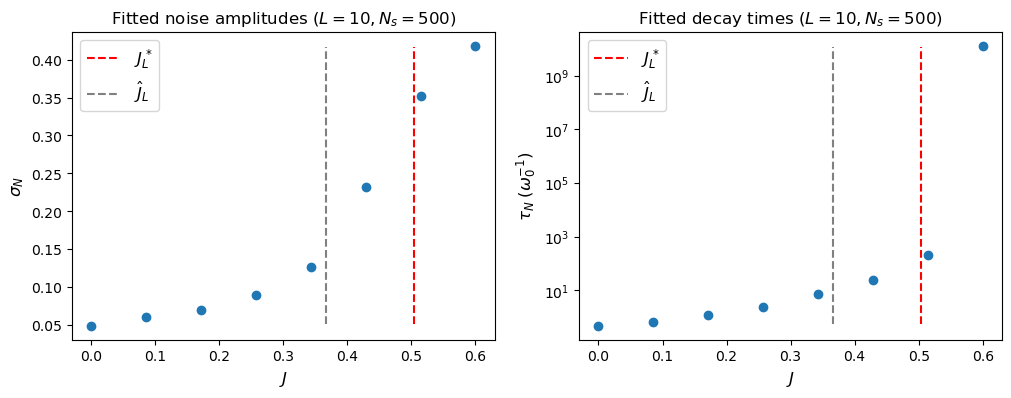

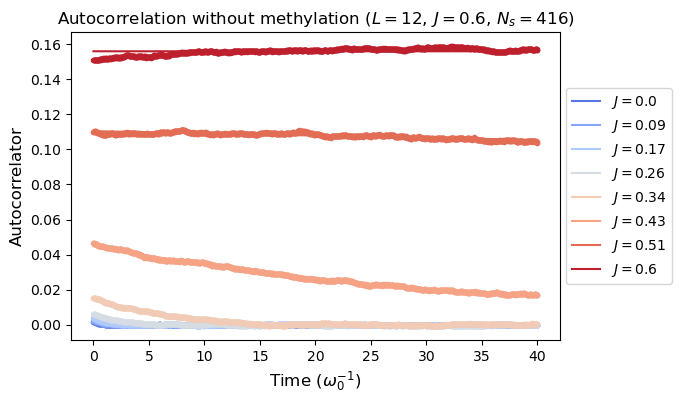

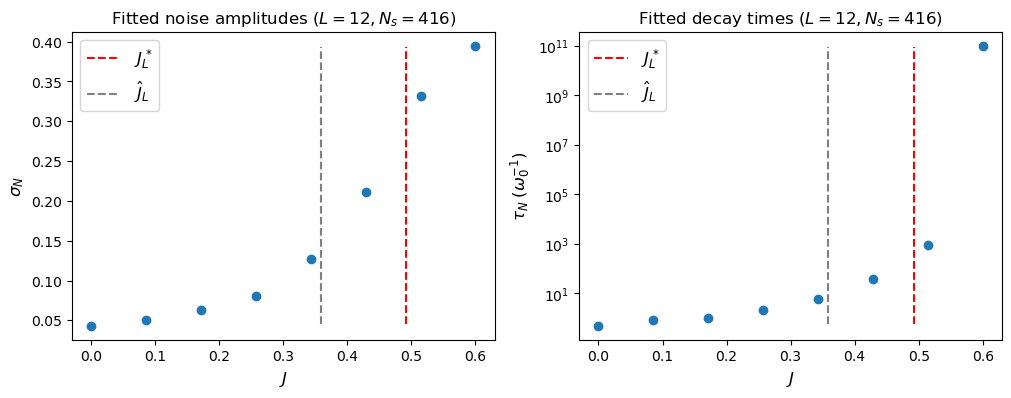

/home/ipausers/zewe/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


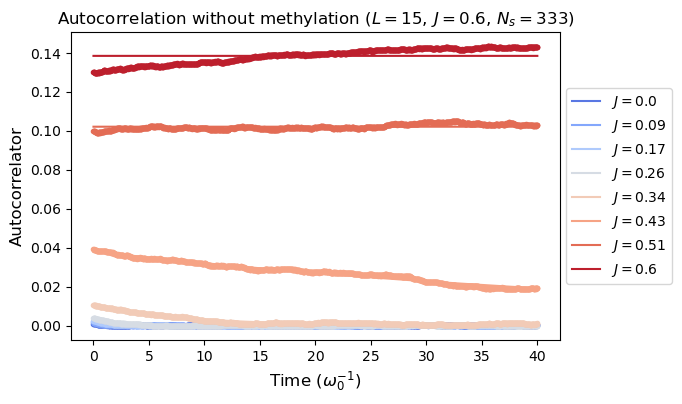

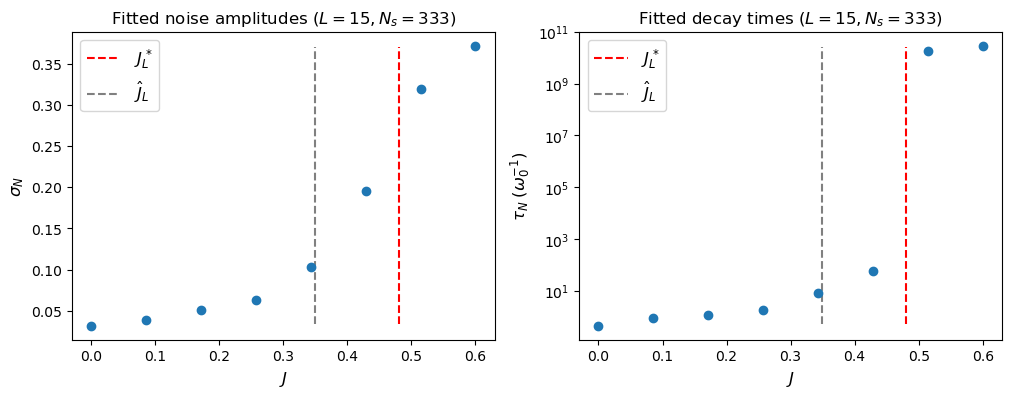

In [33]:
# parameters
n_steps = 3000
tf = 80
co = 1500
Nc = 1
J_arr = np.linspace(0.,0.6,8)

# estimated coupling constants from response kernel with corresponding sizes
J_est_arr = np.array([0.46162382, 0.42166814, 0.38403463, 0.36632255, 0.35628325, 0.34909898, 0.3412954])
omega0_est_arr = np.array([91.140305, 78.43393 , 67.693855, 65.18401 , 64.73763 , 63.322254, 61.320923])
L_arr = np.array([5,6,8,10,12,15,20])

# simulate noise kernels for various L and J
for i,L in enumerate(L_arr):
    n_samples = 5000//L
    J_est = J_est_arr[i]
    noise_estimator(n_samples,Nc,L,J_arr,n_steps,co,tf,J_est,global_plot=True,lin_regress=False)

In [ ]:
# estimates from response kernel
J_est_arr = np.array([0.4652023 , 0.4200491 , 0.38443822, 0.36694324, 0.35833198, 0.34872052])
omega0_est_arr = np.array([88.61115, 74.59032, 70.72732, 67.9984, 63.4537, 61.660194])
L_arr = np.array([5,6,8,10,12,15])